In [1]:
import os
import glob
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import exposure
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score,
                             confusion_matrix, classification_report, precision_recall_curve)
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
import joblib
import rasterio
from rasterio.features import geometry_mask
import geopandas as gpd
import matplotlib.colors as mcolors
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [2]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels from images
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [3]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values


In [7]:
# Function to apply undersampling followed by SMOTE
def apply_resampling(train_df, undersample_target, smote_target):
    # First, we need to undersample the majority classes
    undersampler = RandomUnderSampler(sampling_strategy=undersample_target, random_state=42)
    
    # Prepare the training data
    X_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values
    y_train = train_df['encoded_labels'].values
    
    # Apply undersampling
    X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)
    
   # Adjust SMOTE target to ensure it's not less than the undersampled count
    smote_target_adjusted = {}
    undersampled_counts = Counter(y_undersampled)
    
    for class_label, count in smote_target.items():
        if class_label in undersampled_counts:
            smote_target_adjusted[class_label] = max(count, undersampled_counts[class_label])
    
    # Then, we apply SMOTE to the undersampled data
    smote = SMOTE(sampling_strategy=smote_target_adjusted, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_undersampled, y_undersampled)
    
    return X_resampled, y_resampled

In [8]:
# Define the undersampling and SMOTE target strategies
undersample_target = {
    le.transform(['ocean'])[0]: 1000,
    le.transform(['rock'])[0]: 1000,
    le.transform(['freshwater'])[0]: 1000,
    le.transform(['ice'])[0]: 1000
}

smote_target = {
    le.transform(['walrus_pure'])[0]: 200,
    le.transform(['walrus_mixed'])[0]: 200
}

In [9]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, cohen_kappa_score, confusion_matrix, classification_report, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

In [10]:
# Apply the resampling
X_train_resampled, y_train_resampled = apply_resampling(train_df, undersample_target, smote_target)

# Function to print class distribution
def print_class_distribution(labels, name):
    class_counts = pd.Series(labels).value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Print class distribution for the resampled training data
print_class_distribution(y_train_resampled, "Resampled Training Data")


Resampled Training Data Class Distribution:
freshwater: 1000
ice: 1000
ocean: 1000
rock: 1000
walrus_mixed: 637
walrus_pure: 200


In [11]:
# Train the Random Forest model using the resampled data
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

# Save the model
model_filename = "RF_allislands_resampled.joblib"
joblib.dump(model, model_filename)

['RF_allislands_resampled.joblib']

Accuracy: 0.9498901968216821
Precision: 0.9715048316359823
Recall: 0.9498901968216821
F1 Score: 0.9588623025536595
Cohen's Kappa: 0.9054657159393416

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.62      0.91      0.74      8050
         ice       0.97      0.87      0.92     60047
       ocean       1.00      0.99      0.99    155858
        rock       0.92      0.92      0.92     18571
walrus_mixed       0.03      0.87      0.06       159
 walrus_pure       0.20      1.00      0.33        22

    accuracy                           0.95    242707
   macro avg       0.62      0.93      0.66    242707
weighted avg       0.97      0.95      0.96    242707


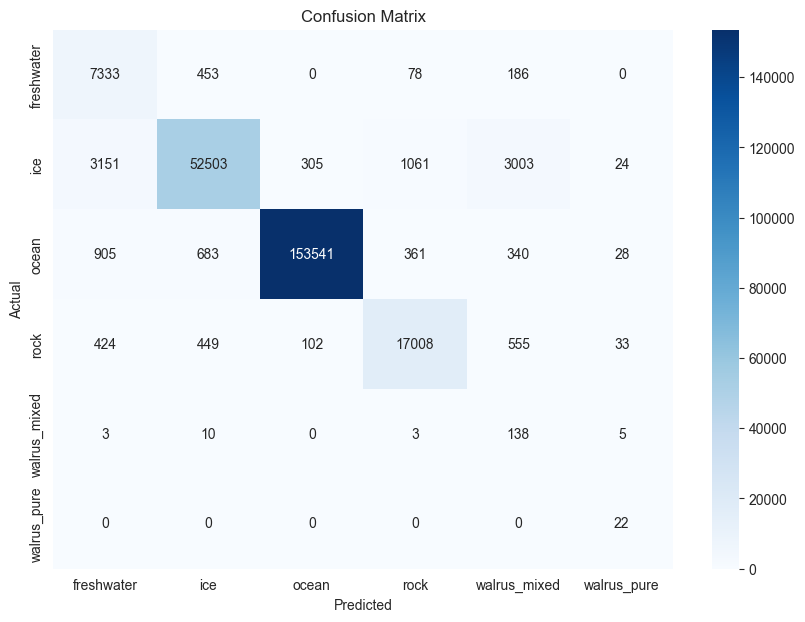

ValueError: multiclass format is not supported

In [12]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


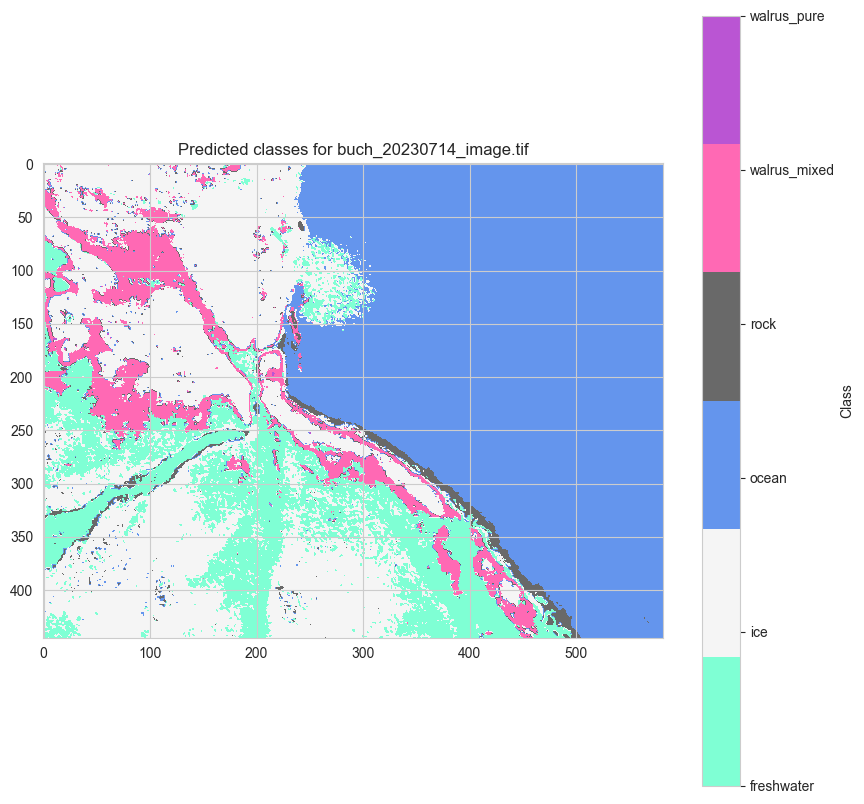

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


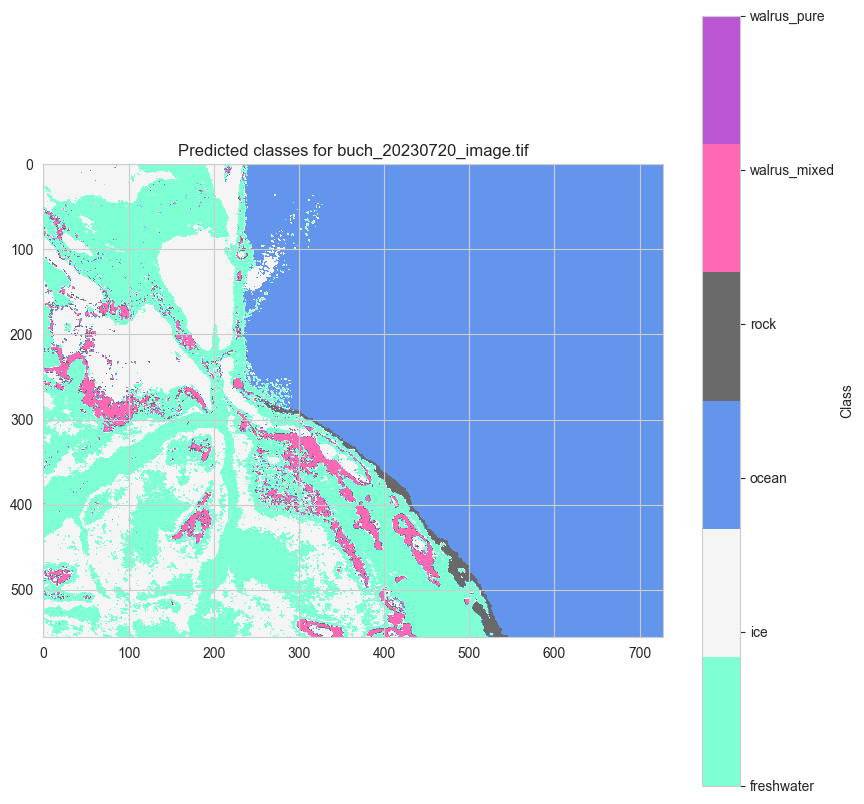

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


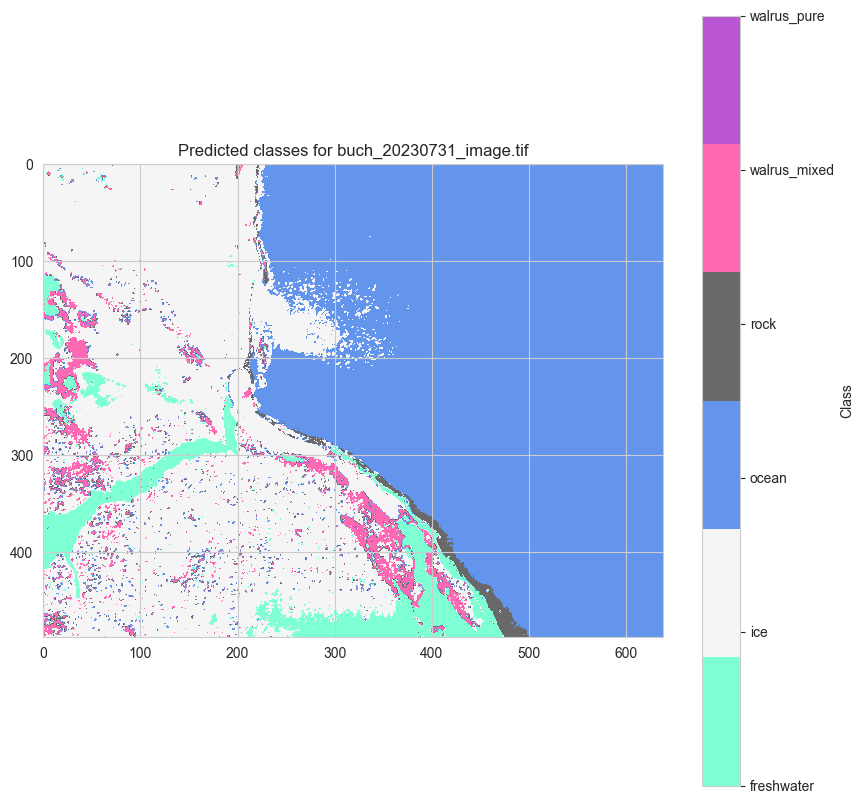

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


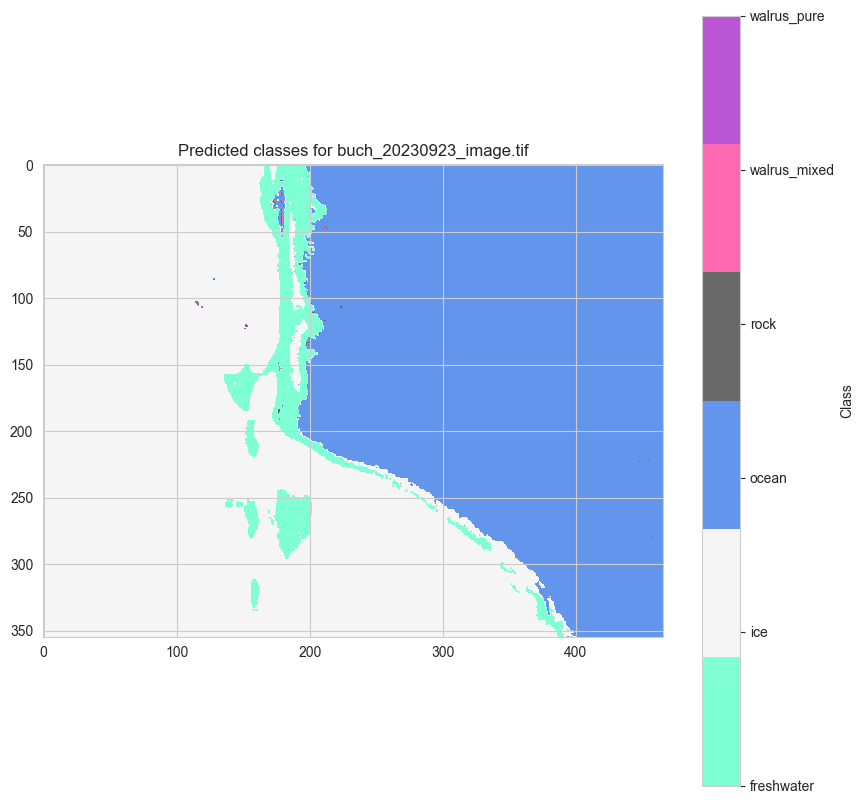

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


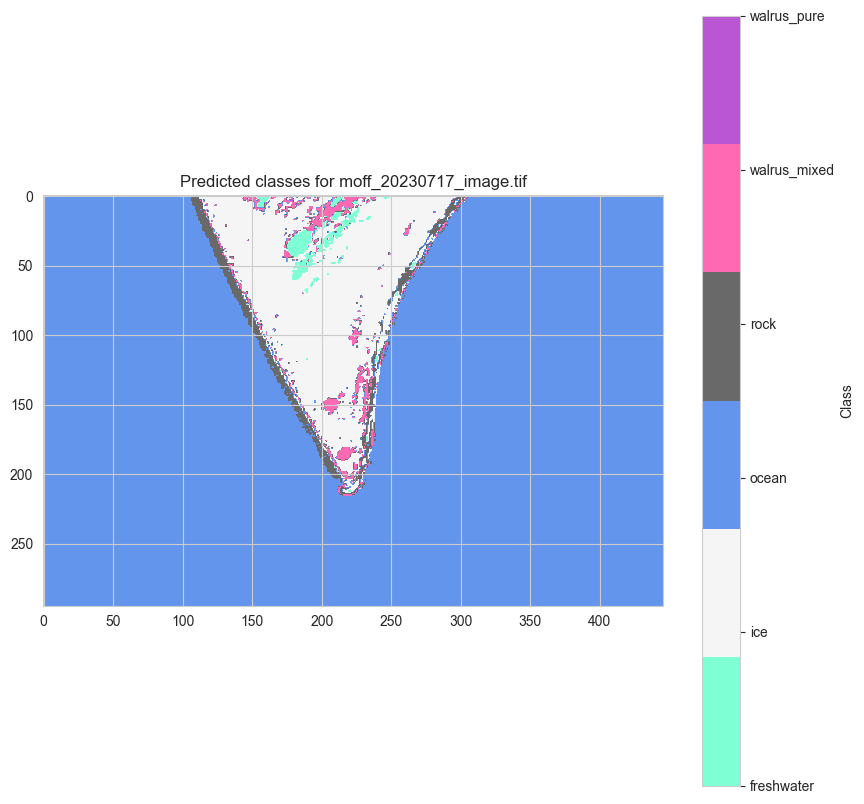

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


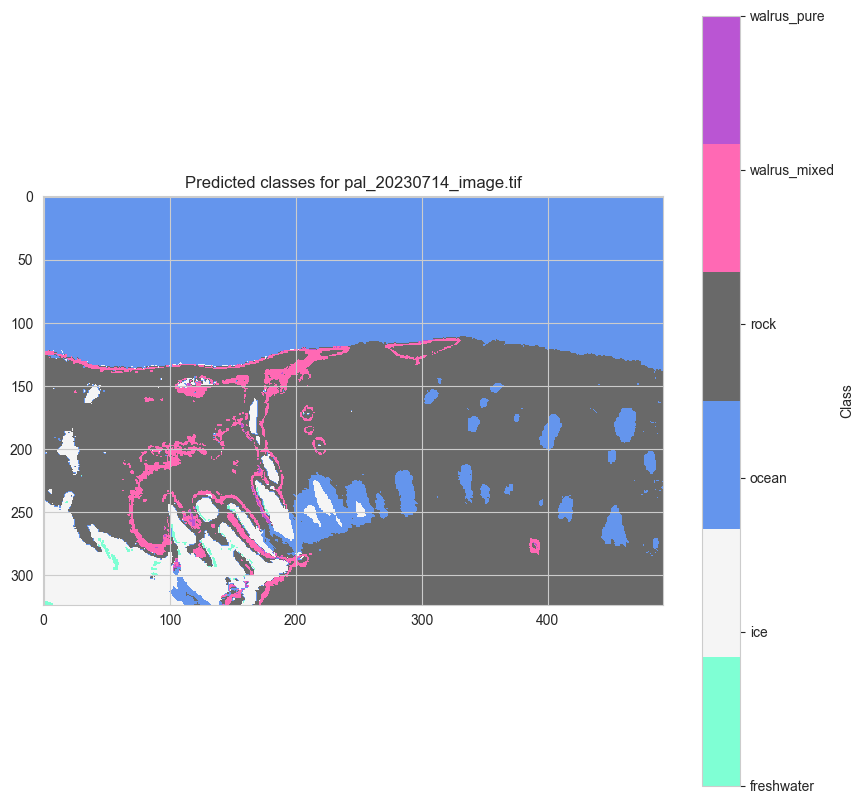

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


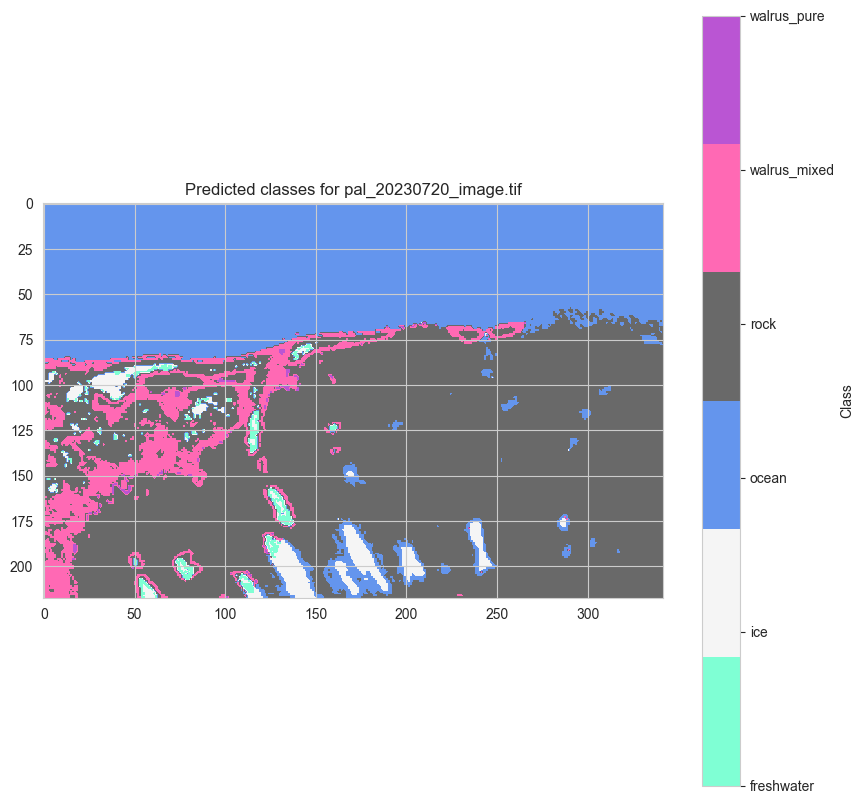

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


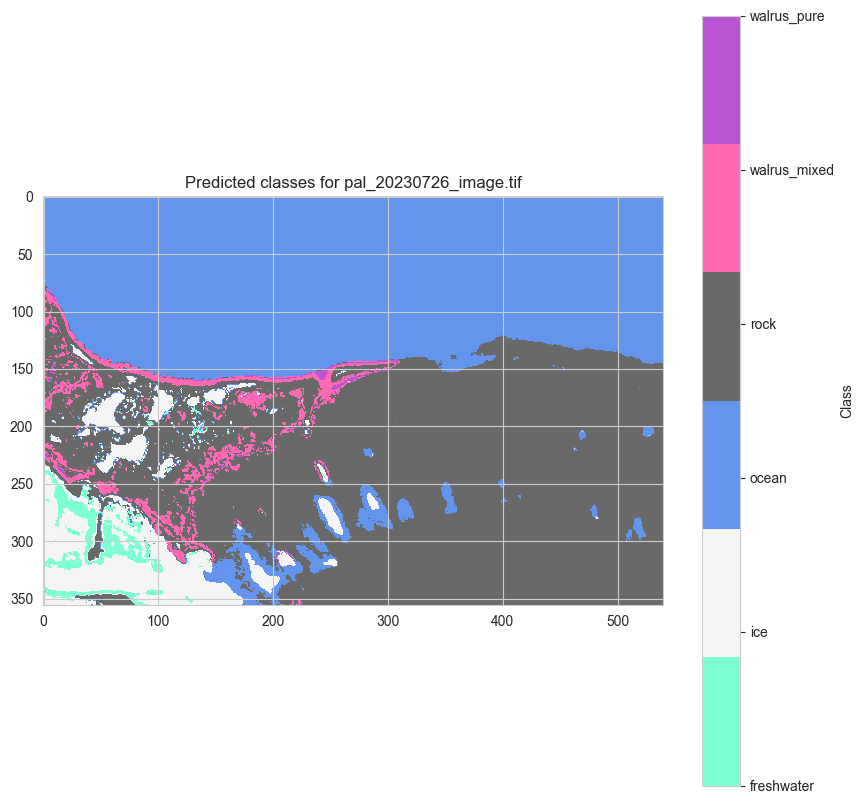

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


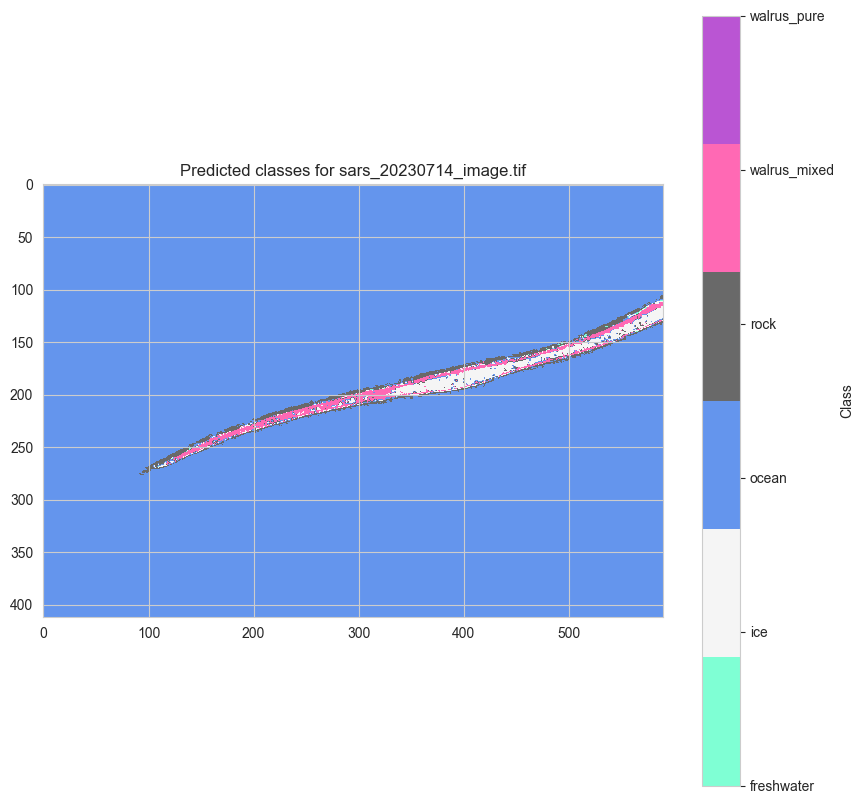

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


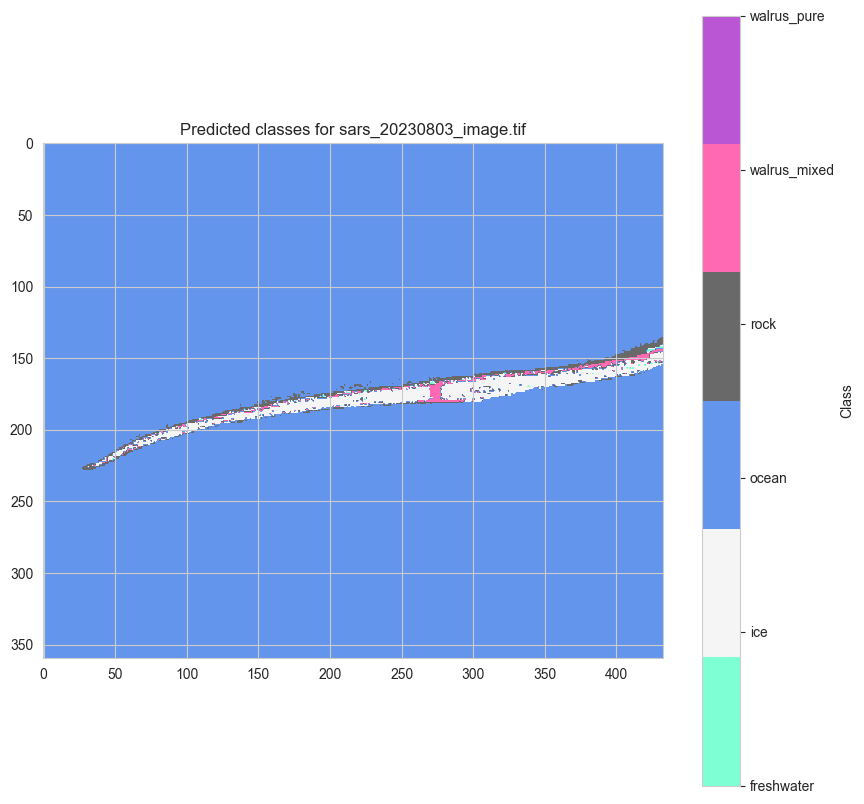

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


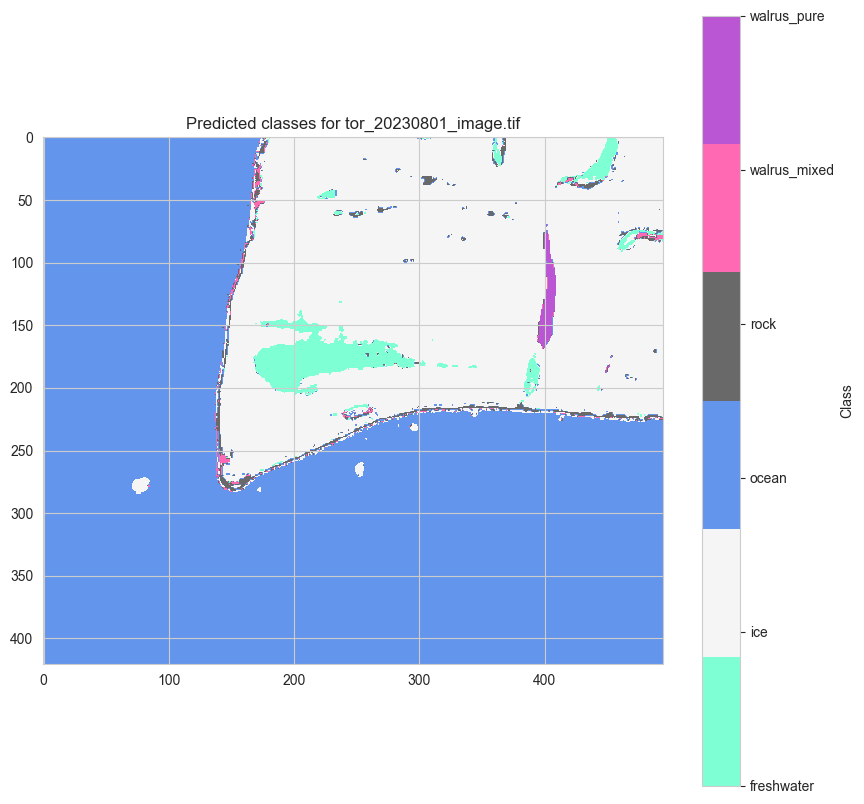

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


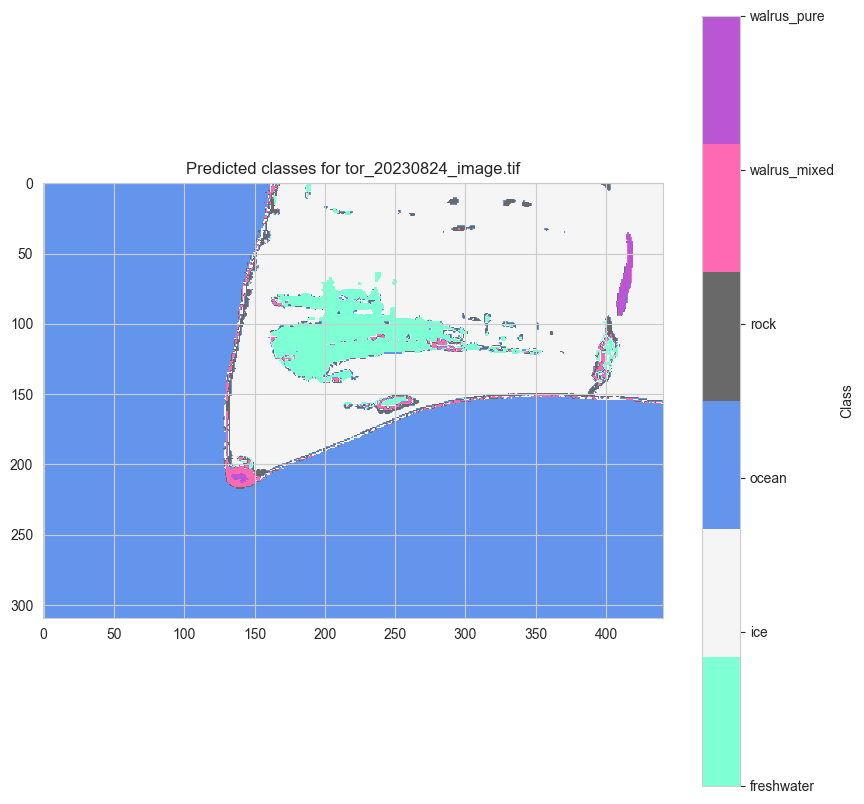

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


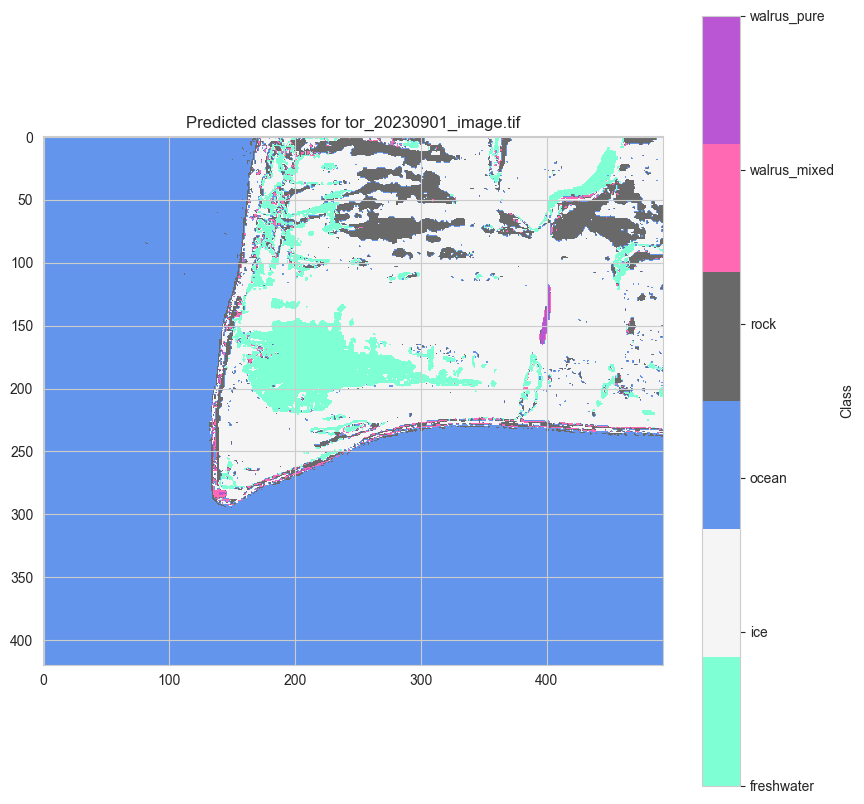

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


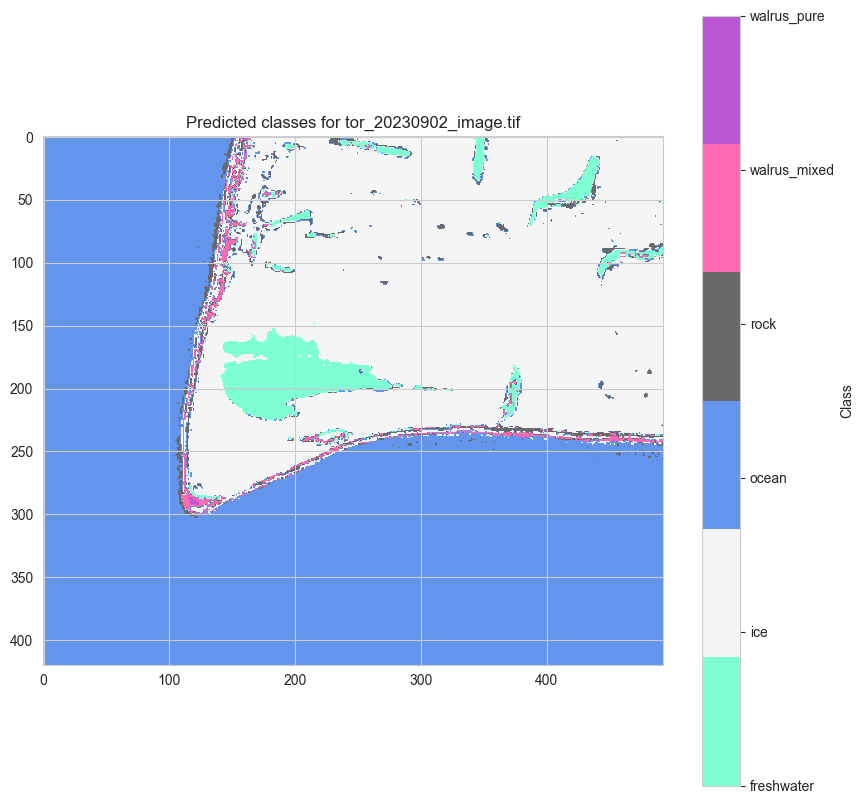

In [15]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()
    

In [ ]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()

In [21]:
from sklearn.utils.class_weight import compute_class_weight

In [16]:
# Define the directories containing images and shapefiles
image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_images"
shapefile_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_train"
unlabeled_image_dir = "C:\\Users\\Student\\Documents\\101_walrus_data\\train\\clipped_unlabeled"

# Use glob to list all .tif and .shp files in the specified directories
image_paths = glob.glob(f"{image_dir}/*.tif")
shapefile_paths = glob.glob(f"{shapefile_dir}/*.shp")
unlabeled_image_paths = glob.glob(f"{unlabeled_image_dir}/*.tif")

# Function to extract island name and date from file names
def extract_island_and_date(filename):
    pattern = r'([a-zA-Z]+)_(\d{8})'
    match = re.search(pattern, filename)
    if match:
        return match.group(1), match.group(2)
    return None, None

# Pair image and shapefile paths based on filenames
def pair_files(image_paths, shapefile_paths):
    file_pairs = {}
    for image_path in image_paths:
        island, date = extract_island_and_date(os.path.basename(image_path))
        if island is None or date is None:
            print(f"Failed to extract island and date from {image_path}")
            continue

        matching_shapefiles = [shapefile for shapefile in shapefile_paths if island in shapefile and date in shapefile]
        if not matching_shapefiles:
            print(f"No matching shapefile found for {image_path}")
            continue

        shapefile_path = matching_shapefiles[0]
        file_pairs[image_path] = shapefile_path
    return file_pairs

file_pairs = pair_files(image_paths, shapefile_paths)

# Function to extract features and labels from images
def extract_features_labels(image_path, shapefile_path):
    with rasterio.open(image_path) as src:
        image = src.read()
        transform = src.transform

    gdf = gpd.read_file(shapefile_path)
    features = []
    labels = []
    img_name = []

    for _, row in gdf.iterrows():
        mask = geometry_mask([row['geometry']], transform=transform, invert=True, out_shape=(src.height, src.width))
        feature_pixels = image[:, mask]
        label = row['label']

        for pixel in feature_pixels.T:  # Transpose to iterate over pixels
            features.append(pixel)
            labels.append(label)
            img_name.append(image_path)

    return np.array(features), np.array(labels), np.array(img_name)

# Extract features and labels for all image-shapefile pairs
def get_dataset(file_pairs):
    features = []
    labels = []
    image_name = []

    for image_path, shapefile_path in file_pairs.items():
        img_features, img_labels, img_name = extract_features_labels(image_path, shapefile_path)
        features.append(img_features)
        labels.append(img_labels)
        image_name.append(img_name)

    features = np.vstack(features)
    labels = np.hstack(labels)
    image_name = np.hstack(image_name)
    return features, labels, image_name

features, labels, image_name = get_dataset(file_pairs)

# Encode labels
le = LabelEncoder()
encoded_labels = le.fit_transform(labels)

# Create DataFrame
dataset = pd.DataFrame({
    'Coast_blue': features[:, 0],
    'Blue': features[:, 1],
    'Green1': features[:, 2],
    'Green': features[:, 3],
    'Yellow': features[:, 4],
    'Red': features[:, 5],
    'Red_edge': features[:, 6],
    'NIR': features[:, 7],
    'labels': labels,
    'encoded_labels': encoded_labels,
    'image_name': image_name
})

No matching shapefile found for C:\Users\Student\Documents\101_walrus_data\train\clipped_images\pool_20230803_image.tif


In [17]:
# Custom function to ensure each island and rare classes are in the train set
def custom_train_test_split(df, test_size=0.2):
    skf = StratifiedKFold(n_splits=int(1/test_size), shuffle=True, random_state=42)
    for train_index, test_index in skf.split(df, df['encoded_labels']):
        train_df = df.iloc[train_index]
        test_df = df.iloc[test_index]
        # Ensure that rare classes are in the training set
        if not all(cls in train_df['encoded_labels'].values for cls in [le.transform(['walrus_pure'])[0], le.transform(['walrus_mixed'])[0]]):
            continue
        # Ensure each island is in the training set
        unique_islands = df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique()
        if all(island in train_df['image_name'].apply(lambda x: extract_island_and_date(x)[0]).unique() for island in unique_islands):
            return train_df, test_df
    return train_df, test_df

# Split the data
train_df, test_df = custom_train_test_split(dataset)
X_train, y_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, train_df['encoded_labels'].values
X_test, y_test = test_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values, test_df['encoded_labels'].values


In [19]:
# Function to apply undersampling followed by SMOTE
def apply_resampling(train_df, undersample_target, smote_target):
    # First, we need to undersample the majority classes
    undersampler = RandomUnderSampler(sampling_strategy=undersample_target, random_state=42)
    
    # Prepare the training data
    X_train = train_df.drop(columns=['labels', 'encoded_labels', 'image_name']).values
    y_train = train_df['encoded_labels'].values
    
    # Apply undersampling
    X_undersampled, y_undersampled = undersampler.fit_resample(X_train, y_train)
    
    # Print the class distribution after undersampling
    print_class_distribution(y_undersampled, "After Undersampling")

    # Adjust SMOTE target to ensure it's not less than the undersampled count
    smote_target_adjusted = {}
    undersampled_counts = Counter(y_undersampled)
    
    for class_label, count in smote_target.items():
        if class_label in undersampled_counts:
            smote_target_adjusted[class_label] = max(count, undersampled_counts[class_label])
    
    # Then, we apply SMOTE to the undersampled data
    smote = SMOTE(sampling_strategy=smote_target_adjusted, random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X_undersampled, y_undersampled)
    
    return X_resampled, y_resampled

# Define the undersampling and SMOTE target strategies
undersample_target = {
    le.transform(['ocean'])[0]: 1000,
    le.transform(['rock'])[0]: 1000,
    le.transform(['freshwater'])[0]: 1000,
    le.transform(['ice'])[0]: 1000
}

smote_target = {
    le.transform(['walrus_pure'])[0]: 200,
    le.transform(['walrus_mixed'])[0]: 200
}

# Apply the resampling
X_train_resampled, y_train_resampled = apply_resampling(train_df, undersample_target, smote_target)

# Function to print class distribution
def print_class_distribution(labels, name):
    class_counts = pd.Series(labels).value_counts()
    class_names = le.inverse_transform(class_counts.index)
    print(f"\n{name} Class Distribution:")
    for class_name, count in zip(class_names, class_counts):
        print(f"{class_name}: {count}")

# Print class distribution for the resampled training data
print_class_distribution(y_train_resampled, "Resampled Training Data")


After Undersampling Class Distribution:
freshwater: 1000
ice: 1000
ocean: 1000
rock: 1000
walrus_mixed: 637
walrus_pure: 91

Resampled Training Data Class Distribution:
freshwater: 1000
ice: 1000
ocean: 1000
rock: 1000
walrus_mixed: 637
walrus_pure: 200


In [22]:
# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_resampled), y=y_train_resampled)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Train the Random Forest model using the resampled data and class weights
model = RandomForestClassifier(n_estimators=500, random_state=42, class_weight=class_weights_dict)
model.fit(X_train_resampled, y_train_resampled)

# Save the model
model_filename = "RF_allislands_resampled_class_weighted.joblib"
joblib.dump(model, model_filename)

['RF_allislands_resampled_class_weighted.joblib']

Accuracy: 0.9514146687157766
Precision: 0.9718430483707239
Recall: 0.9514146687157766
F1 Score: 0.9598920734905227
Cohen's Kappa: 0.9082759909940805

Classification Report:
              precision    recall  f1-score   support

  freshwater       0.63      0.91      0.74      8050
         ice       0.97      0.88      0.92     60047
       ocean       1.00      0.99      0.99    155858
        rock       0.92      0.91      0.92     18571
walrus_mixed       0.03      0.86      0.07       159
 walrus_pure       0.31      1.00      0.47        22

    accuracy                           0.95    242707
   macro avg       0.64      0.93      0.69    242707
weighted avg       0.97      0.95      0.96    242707


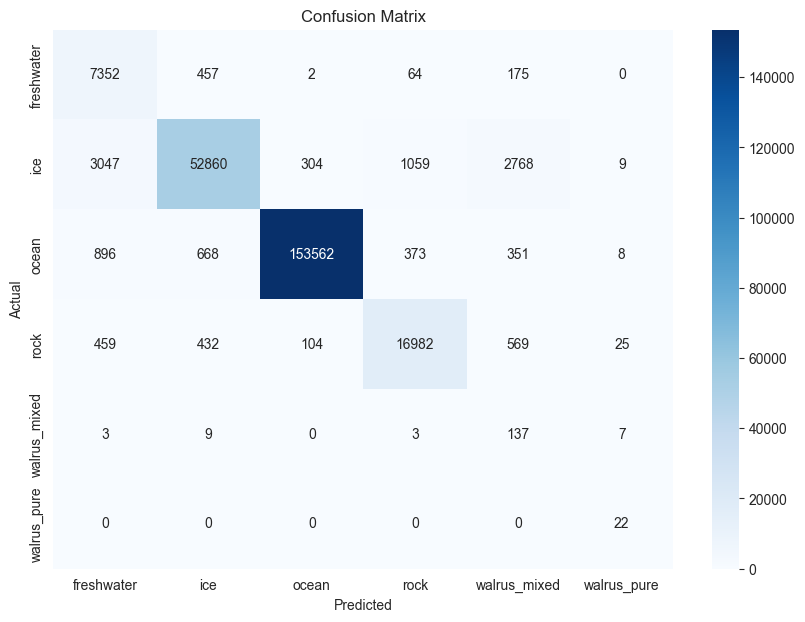

ValueError: multiclass format is not supported

In [23]:
# Evaluate the model
y_pred = model.predict(X_test)

# Calculate and print evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
kappa = cohen_kappa_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Cohen's Kappa: {kappa}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

Labels present in buch_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


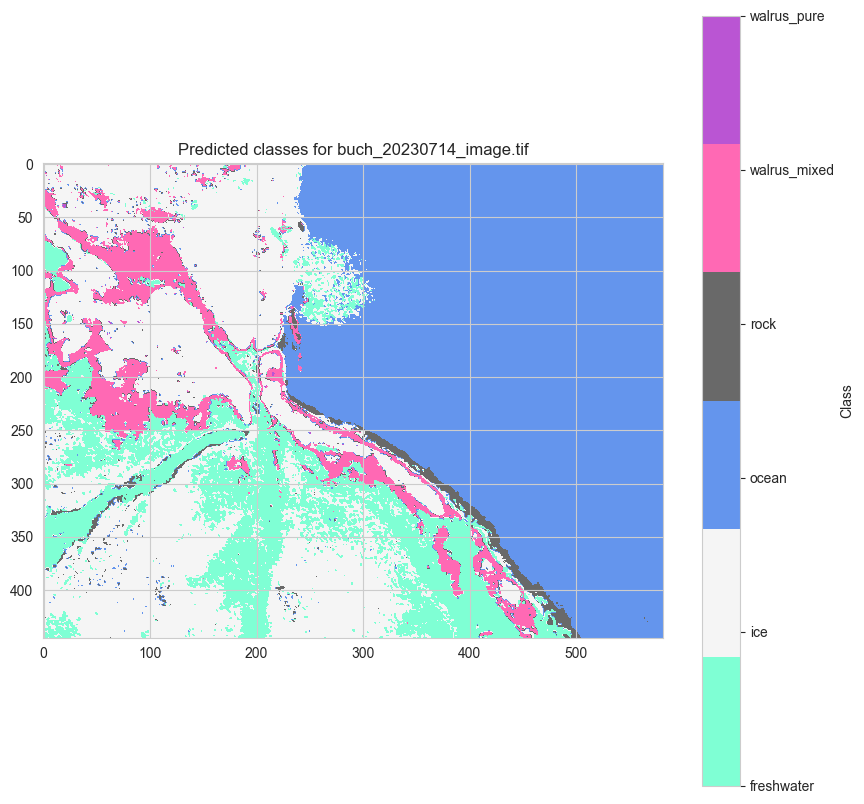

Labels present in buch_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


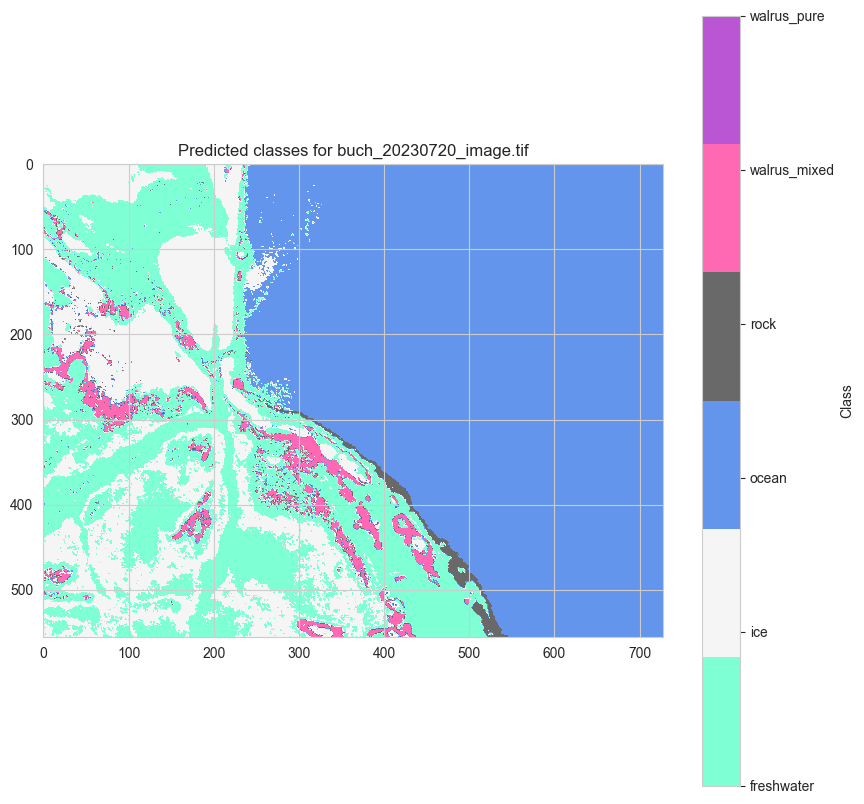

Labels present in buch_20230731_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


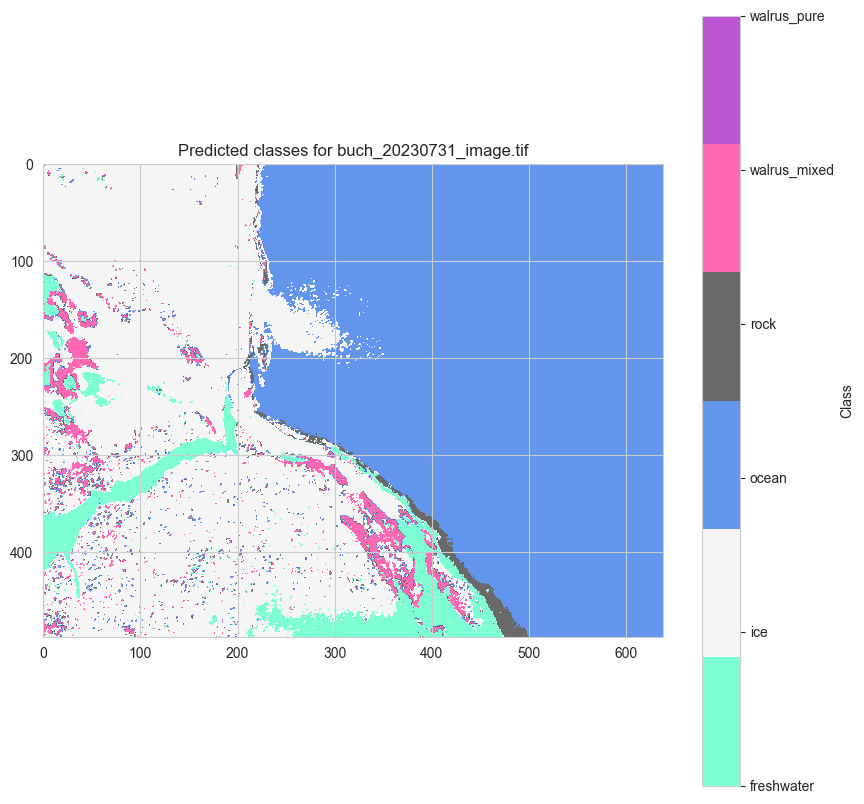

Labels present in buch_20230923_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


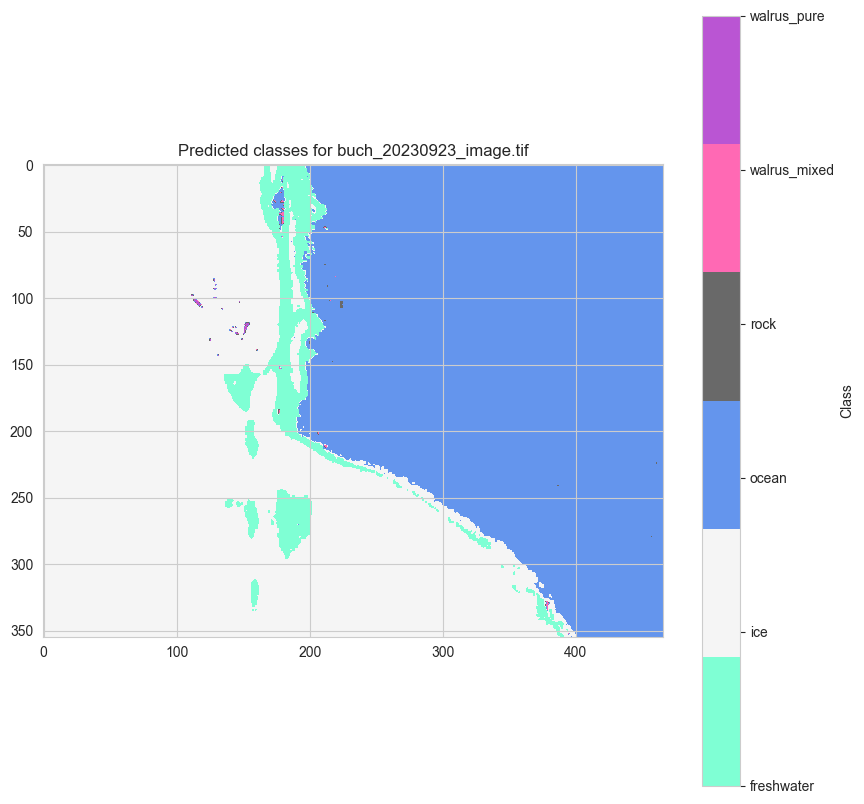

Labels present in moff_20230717_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


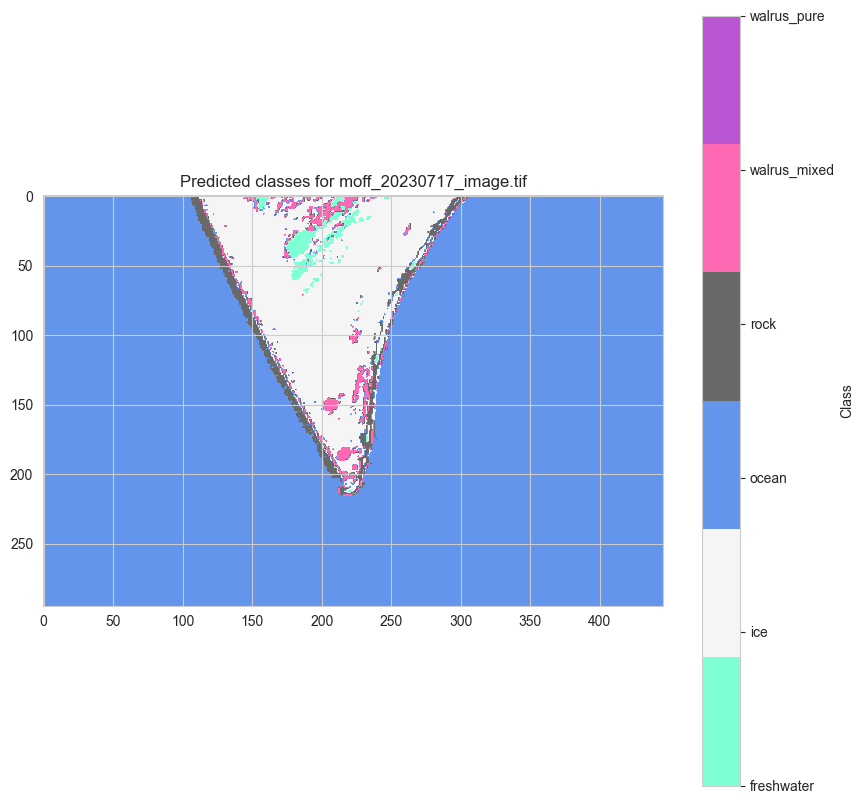

Labels present in pal_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


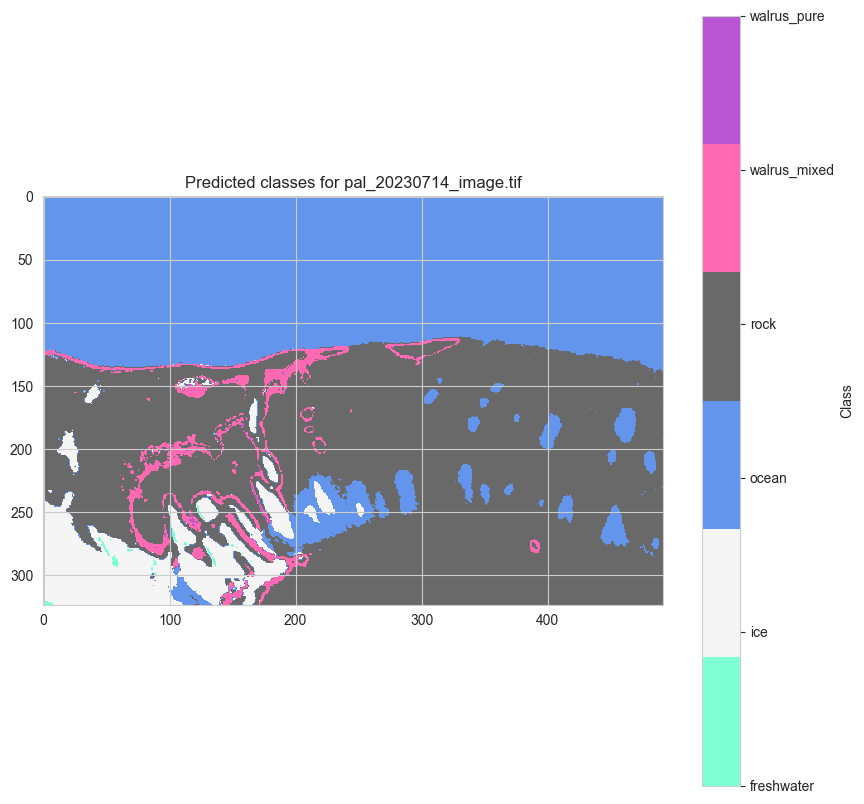

Labels present in pal_20230720_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


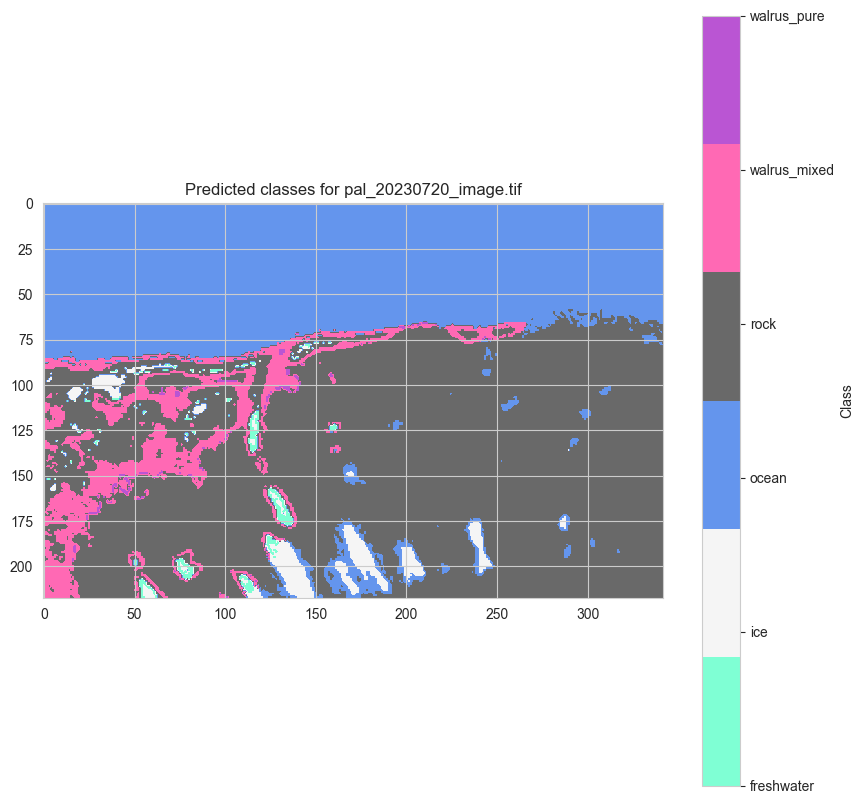

Labels present in pal_20230726_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


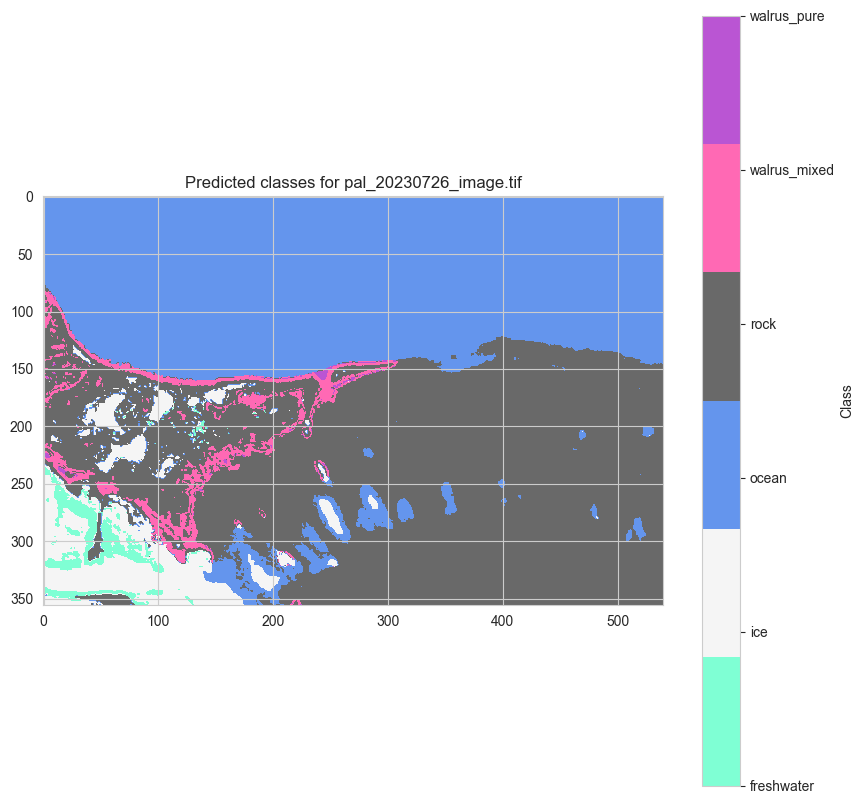

Labels present in sars_20230714_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


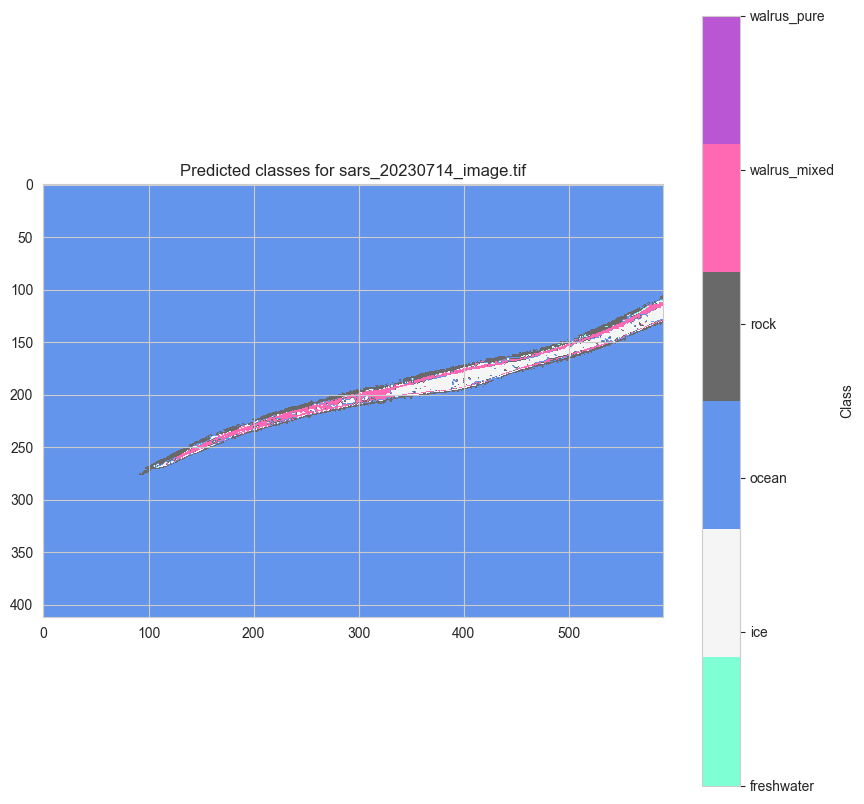

Labels present in sars_20230803_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed']


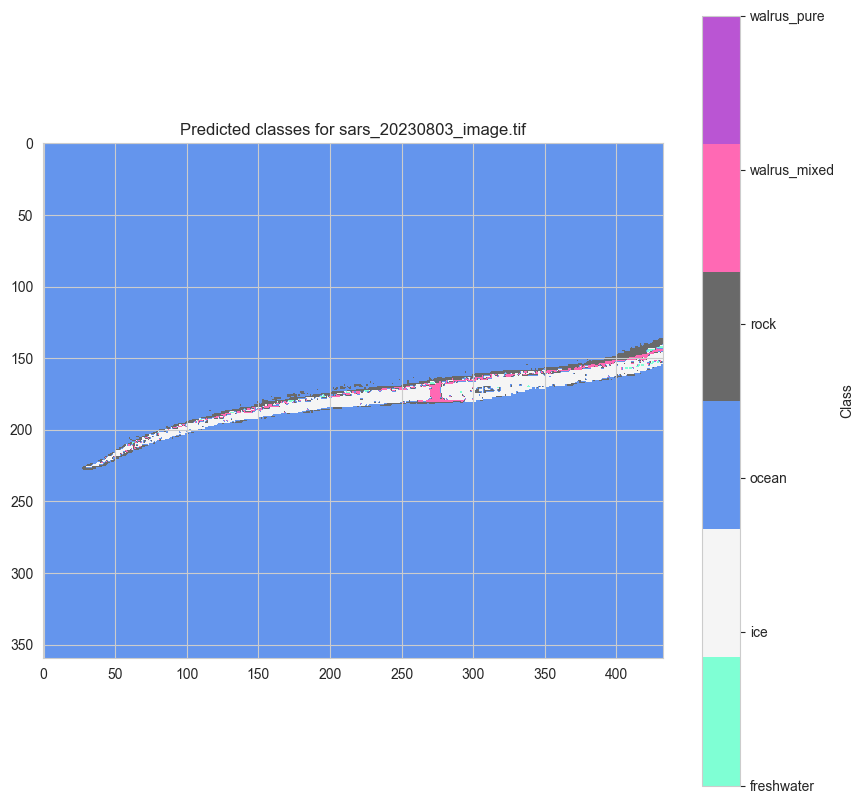

Labels present in tor_20230801_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


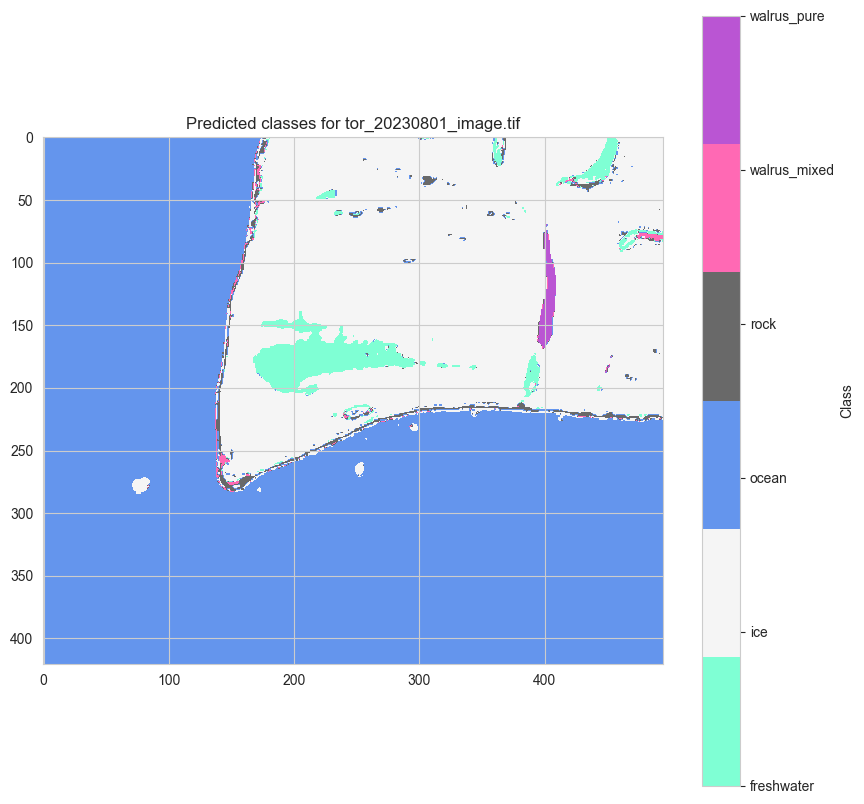

Labels present in tor_20230824_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


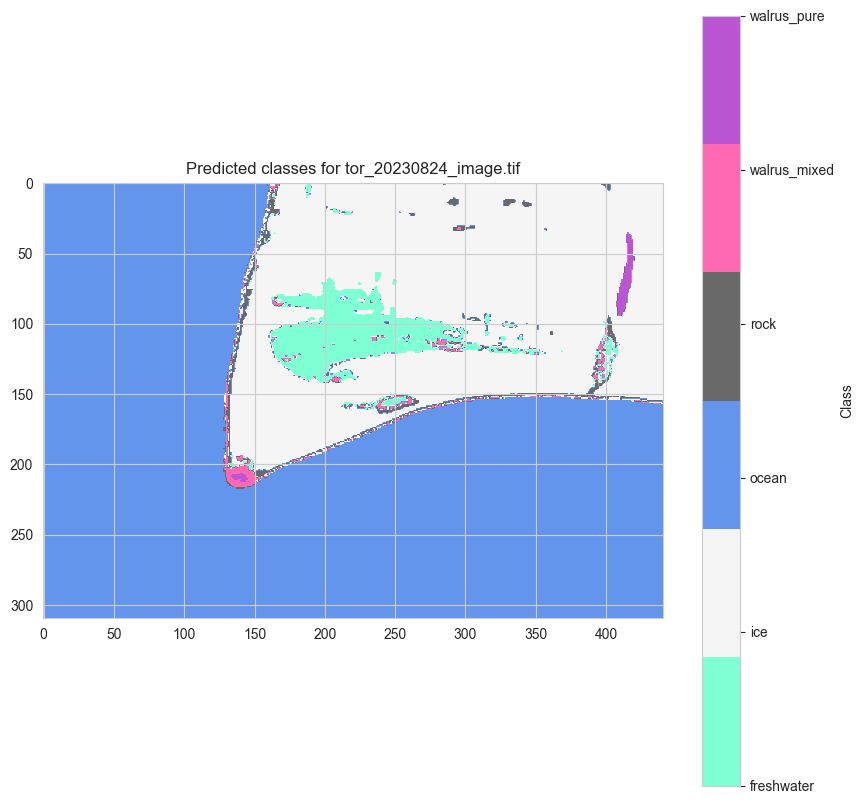

Labels present in tor_20230901_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


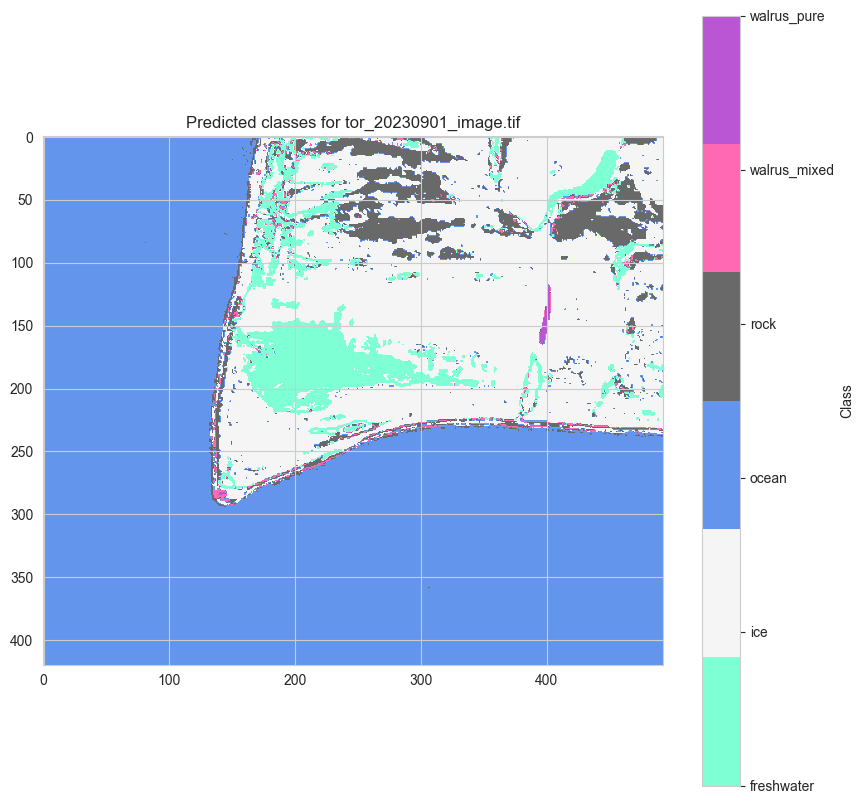

Labels present in tor_20230902_image.tif: ['freshwater', 'ice', 'ocean', 'rock', 'walrus_mixed', 'walrus_pure']


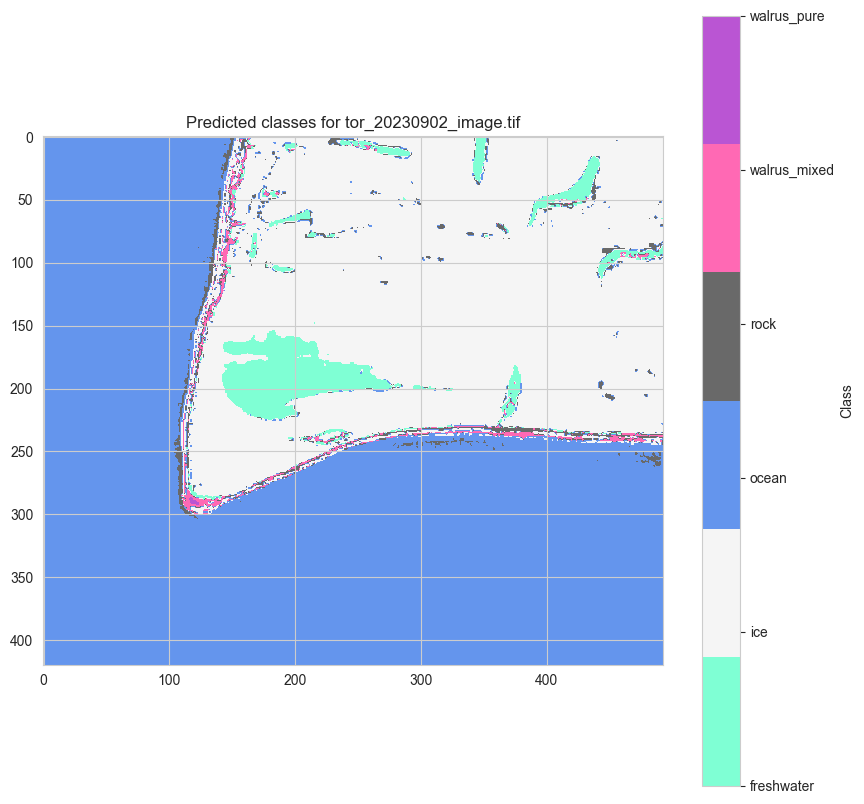

In [24]:
# Function to predict classes for a given image
def predict_image(image_path, model):
    with rasterio.open(image_path) as src:
        image = src.read()
        image_reshaped = image.reshape((image.shape[0], -1)).T
        predictions = model.predict(image_reshaped)
        return predictions.reshape((src.height, src.width))

predicted_images = {}

for image_path, shapefile_path in file_pairs.items():
    predicted_images[image_path] = predict_image(image_path, model)

label_colors = {
    'ice': 'whitesmoke',
    'ocean': 'cornflowerblue',
    'rock': 'dimgrey',
    'freshwater': 'aquamarine',
    'walrus_pure': 'mediumorchid',
    'walrus_mixed': 'hotpink'
}

# Create a fixed color map based on all possible labels
cmap = mcolors.ListedColormap([label_colors[label] for label in le.classes_])

# Plot the predicted images
for image_path, predicted_image in predicted_images.items():
    unique_labels = np.unique(predicted_image)
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    # Create a color bar with fixed labels
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)  # Set text labels instead of numerical labels
    
    # Highlight the labels present in the current image
    present_labels = [le.classes_[i] for i in unique_labels]
    print(f"Labels present in {os.path.basename(image_path)}: {present_labels}")
    
    plt.show()


In [ ]:
# Load the saved model and predict classes for unlabeled images
loaded_model = joblib.load(model_filename)
print(f"Model loaded from {model_filename}")
for image_path in unlabeled_image_paths:
    predicted_image = predict_image(image_path, loaded_model)
    
    plt.figure(figsize=(10, 10))
    plt.title(f"Predicted classes for {os.path.basename(image_path)}")
    plt.imshow(predicted_image, cmap=cmap, vmin=0, vmax=len(le.classes_)-1)
    
    cbar = plt.colorbar(ticks=range(len(le.classes_)), label='Class')
    cbar.ax.set_yticklabels(le.classes_)
    
    plt.show()